# Cov-SSI on shear frame using KOMA

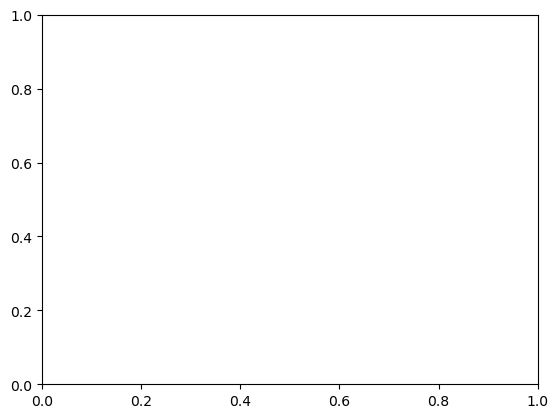

In [1]:
import koma.oma, koma.plot

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, welch, resample

import matplotlib.pyplot as plt

from beef.newmark import newmark_lin
from knutils.modal import statespace as to_A
from knutils.structural import shearframe

In [2]:
# Convenience functions
def plot_mode(ax, phi, scaling=1.0):
    levels = len(phi)
    phi_plot = np.hstack([0, phi])
    
    if scaling is not None:
        maxval = np.max(np.abs(np.real(phi_plot)))
        phi_plot = phi_plot/maxval * scaling

    handle = [None]*(levels+2)
    
    handle[0] = ax.plot(phi_plot-0.5, np.arange(levels+1), color='black')[0]
    handle[1] = ax.plot(phi_plot+0.5, np.arange(levels+1), color='black')[0]
    
    for level in range(levels):
        handle[level+2] = ax.plot([phi_plot[level+1]-0.5, phi_plot[level+1]+0.5], [level+1, level+1], color='black')[0]

    return handle

def plot_all_modes(levels, phi, phi_ref):
    # Mode shapes: simple plots
    fig, ax = plt.subplots(ncols=levels, nrows=1, sharey=True)
    for n in range(phi.shape[1]):
        max_true = np.argmax(np.abs(phi[:, n]))
        flip_factor = np.real(np.sign(phi[max_true, n]/phi_ref[max_true, n]))

        h2 = plot_mode(ax[n], phi_ref[:, n]*flip_factor)
        __ = [hi.set(alpha=1.0, color='gray', linestyle='-') for hi in h2]
        h1 = plot_mode(ax[n], phi[:, n])
        __ = [hi.set(alpha=1.0, color='red', linestyle='--') for hi in h1]

        ax[n].set_title(f'Mode {n+1}')
        
    ax[0].set_ylabel('Level')
    return fig, ax

## System definition, analytical solution

In [3]:
levels = 5

k = 8000
m = 500
c = 50

fs = 12.0
tmax = 1200

K, C, M, __ = shearframe(levels, k, c, m, relative_dampers=False)

t = np.arange(0, tmax, 1/fs)

u0 = np.zeros([levels])
udot0 = u0*1

f = np.random.randn(levels, len(t))*1000
displacement, __, acceleration = newmark_lin(K, C, M, f, t, u0, udot0)

data = displacement.T

# Remember to perform necessary preprocessing (filtering, detrending, etc.)
data = detrend(data, axis=0) # scipy.signal.detrend acts on last axis by default (row-wise in matrix) - specify axis=0

noise_factor = 0.6
noise = np.std(data) * noise_factor
data_noised = data + noise*np.random.randn(data.shape[0], data.shape[1])
np.save('data_shearframe.npy', data_noised)

## Analytical eigenvalue solution

In [11]:
A = to_A(K, C, M) # establish state matrix based on K, C and M
lambdai, qi = np.linalg.eig(A)

ix = np.argsort(np.abs(lambdai))
xi_ref = -np.real(lambdai[ix][::2])/np.abs(lambdai[ix][::2])
omega_n_ref = np.abs(lambdai[ix][::2])
phi_ref = np.real(qi[:int(len(ix)/2), ix[::2]])

np.save('omega_n.npy', omega_n_ref)
np.save('xi_ref.npy', xi_ref)
np.save('phi_ref.npy', phi_ref)

## Plot response

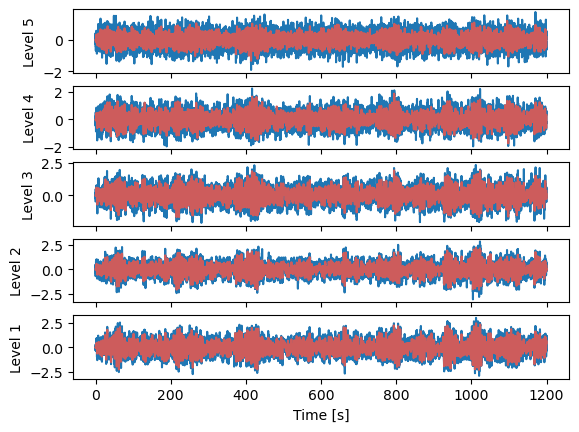

In [5]:
fig, ax = plt.subplots(nrows=levels, ncols=1, num=1, sharex =True)

for level, axi in enumerate(ax[::-1]):    
    axi.plot(t, data_noised[:,level])
    axi.plot(t, data[:,level], color='IndianRed', alpha=1)
    axi.set_ylabel(f'Level {level+1}')

__ = ax[-1].set_xlabel('Time [s]')

## Define SSI parameters

In [6]:
# Cov-SSI parameters
i = 50
orders_input = np.arange(2, 60+2, 2)

# Stabilization analysis parameters
stabcrit = {'freq':0.05, 'damping': 0.2, 'mac': 0.1}
s = 1
valid_range = {'freq': [0, np.inf], 'damping':[0, 0.3], 'mpc': [0.4, 1]}

## Cov-SSI call and stabilization

In [7]:
lambd, phi, orders = koma.oma.covssi(data_noised, fs, i, orders, return_flat=True) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, 
                                                                        stabcrit=stabcrit, valid_range=valid_range, 
                                                                        indicator='freq', use_legacy=False) # Stable poles

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


## Welch PSD estimate

In [8]:
nperseg = 1024
zp = 4
nfft = nperseg*zp

f, Pxx = welch(data_noised[:,0], fs, 'hann', nperseg=nperseg, nfft=nfft)

## Visualization: stabilization plot

In [9]:
fig = koma.plot.stabplot(lambd_stab, orders_stab, psd_freq=f*2*np.pi, psd_y=Pxx/np.pi/2, 
                         frequency_unit='rad/s', freq_range=[0,np.max(omega_n_ref)*1.2], 
                         damped_freq=False)
fig

FigureWidget({
    'data': [{'hovertemplate': '\\omega_n = %{x:.3f} rad/s<br>n = %{y}<br> %{text}',
          …

C:\Users\knutankv\AppData\Local\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



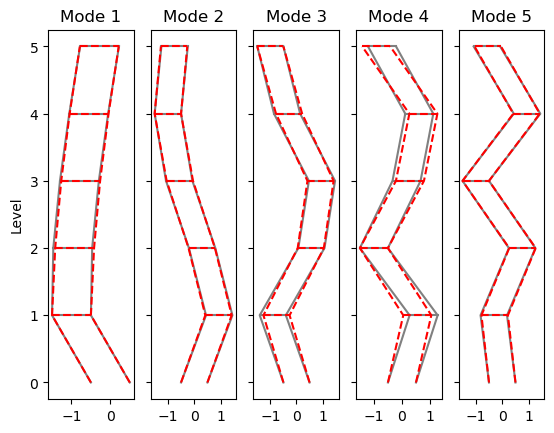

In [10]:
# For plot below poles with indices 1,2,5,9,14 are picked in plot above
# This differs from simulation to simulation due to the noise that is added.

phi_plot = phi_stab[:, [1,2,5,9,14]]
fig, ax = plot_all_modes(levels, phi_ref, phi_plot)